In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
#df_test_trans = pd.read_csv('../input/test_transaction.csv')

df_train_identity = pd.read_csv('../input/train_identity.csv')
#df_test_identity = pd.read_csv('../input/test_identity.csv')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')
#df_test = df_test_trans.merge(df_test_identity, how='left', on='TransactionID')

print(df_train.shape)
#print(df_test.shape)

# Standardizing column names
df_train.columns = df_train.columns.str.replace('-', '_')
#df_test.columns = df_test.columns.str.replace('-', '_')

del df_train_trans, df_train_identity

(590540, 434)


In [4]:
# Reduce memory usage
df_train = reduce_mem_usage(df_train)

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [5]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
    df_train[col] = df_train[col].fillna('Unknown')  # Fill missing values
    df_train[col] = lbl.fit_transform(df_train[col])  # Apply label encoding

df_train.fillna(-999, inplace=True)

    # Select only numerical columns
X_train = df_train.drop(columns=['isFraud'])
y_train = df_train['isFraud']

# Train-test split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.94      0.60      0.73      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.80      0.86    118108
weighted avg       0.98      0.98      0.98    118108



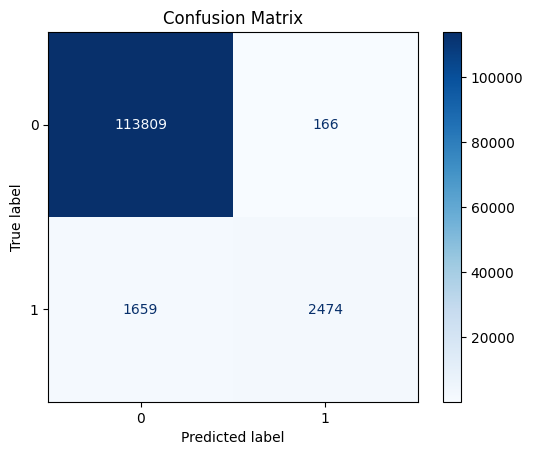

In [6]:
# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# # Initialize PCA and specify number of components (optional)
# pca = PCA(n_components=30)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_val_pca = pca.transform(X_val_scaled)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=300,
    random_state=42
)
# Train the model on PCA-transformed data
model.fit(X_train_scaled, y_train_final)

# Make predictions
y_val_pred = model.predict(X_val_scaled)

# Show classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()